# ARCH & GARCH

- 在TS_2中我们发现虽然序列平稳，但ARMA模型无法很好的拟合(In TS_2 we find that although the sequence is stable, the ARMA model cannot fit well)
- 观察收益率图像可以发现明显的波动聚集，这是异方差性导致的，故本节讨论用于处理异方差性的ARCH和GARCH模型（Observing the yield image can reveal obvious cluster effects, which are caused by heteroscedasticity, so this section discusses the ARCH and GARCH models for dealing with heteroscedasticity）

### 1.导入数据（Import data）

In [2]:
from jqdatasdk import *
import arch
import numpy as np
import matplotlib.pyplot as plt

auth('13241809053','809053')
is_auth = is_auth()

from jqdatasdk import *
import matplotlib.pyplot as plt
auth('13241809053','809053')
is_auth = is_auth()

price = get_price("000001.XSHG", start_date="2015-1-1", end_date="2019-12-31", frequency='daily')['close']
returns = price.pct_change().dropna()

train_price = get_price("000001.XSHG", start_date="2015-1-1", end_date="2019-12-24", frequency='daily')['close']
train_returns = train_price.pct_change().dropna()

test_price = get_price("000001.XSHG", start_date="2019-12-24", end_date="2019-12-31", frequency='daily')['close']
test_returns = test_price.pct_change().dropna()

auth success 


### 2. returns是平稳非纯随机序列，先提取水平信息，用TS_2中的ARMA模型拟合（returns is a stationary non-pure random sequence, first extract level information and fit it with the ARMA model in TS_2）
- 重复TS_2的过程，ARMA(3,2)拟合（Repeat the process of TS_2, ARMA (3,2) fit）

In [3]:
import statsmodels.api as sm
order = (3,2)
train_ar_result = sm.tsa.ARMA(train_returns,order).fit()

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### 3.GARCH模型构建（GARCH model construction）

#### （1）对该训练集残差的平方进行LM检验（ARCH效应检验）（Perform LM test (ARCH effect test) on the square of the training set residuals）
- 检验结果是，拒绝原假设，该序列方差非齐，适用于ARCH模型（The test result is that the null hypothesis is rejected, and the sequence variance is not uniform, which is suitable for the ARCH model.）

In [4]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np

train_resid = train_ar_result.resid
train_resid2 = train_resid ** 2
print("LM: ",acorr_ljungbox(train_resid2, lags=[6, 12]))

LM:  (array([432.4815794 , 575.20989525]), array([2.88855221e-090, 2.07562261e-115]))


#### （2）GARCH模型拟合残差，调整参数找到最优情况（GARCH model fits residuals and adjusts parameters to find the best case）
先来看下arch包中arch_model函数各参数的含义以及模型设定方法。

arch.arch_model(y, x=None, mean='Constant', lags=0, vol='Garch', p=1, o=0, q=1, power=2.0, dist='Normal', hold_back=None)

各参数含义:    
y : 因变量。
x : 外生变量，如果没有外生变量则模型自动省略。  
mean: 均值模型的名称，可选: ‘Constant’, ‘Zero’, ‘ARX’ 以及 ‘HARX’。  
lags:滞后阶数。  
vol :波动率模型，可选: ‘GARCH’ （默认）, ‘ARCH’, ‘EGARCH’, ‘FIARCH’ 以及 ‘HARCH’。  
p :– 对称随机数的滞后阶,即扣除均值后的部分。  
o ：非对称数据的滞后阶。  
q ：波动率或对应变量的滞后阶。  
power：使用GARCH或相关模型的精度。  
dist：误差分布，可选：正态分布: ‘normal’, ‘gaussian’ (default)；学生T分布: ‘t’, ‘studentst’；偏态学生T分布: ‘skewstudent’, ‘skewt’；通用误差分布: ‘ged’, ‘generalized error”。  
hold_back：对同一样本使用不同的滞后阶来比较模型时使用该参数。

In [5]:
from arch import *
train_garch = arch_model(train_resid,p=1,o=0,q=1,dist='gaussian',mean = "ZERO")
train_garch_result = train_garch.fit(update_freq=0)
print(train_garch_result.summary())

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3666.4470406979535
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                3666.45
Distribution:                  Normal   AIC:                          -7326.89
Method:            Maximum Likelihood   BIC:                          -7311.59
                                        No. Observations:                 1213
Date:                Thu, Jan 30 2020   Df Residuals:                     1210
Time:                        03:01:16   Df Model:                            3
                              Volatility Model                         

D:\anaconda\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002157. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
D:\anaconda\lib\site-packages\arch\univariate\base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


### 4. ARMA-Garch预测波动率（predict volatility）

- 构建残差序列（Constructing a residual sequence）

In [6]:
import numpy as np
test_resid=[train_ar_result.resid[-2],train_ar_result.resid[-1]]
test_resid.append(test_returns[0]-train_ar_result.params[1]*train_returns[-1]
                  -train_ar_result.params[2]*train_returns[-2]
                  -train_ar_result.params[3]*train_returns[-3]
                  -train_ar_result.params[4]*test_resid[-1]-train_ar_result.params[5]*test_resid[-2])
test_resid.append(test_returns[1]-train_ar_result.params[1]*test_returns[0]
                  -train_ar_result.params[2]*train_returns[-1]
                  -train_ar_result.params[3]*train_returns[-2]
                  -train_ar_result.params[4]*test_resid[-1]-train_ar_result.params[5]*test_resid[-2])
test_resid.append(test_returns[2]-train_ar_result.params[1]*test_returns[1]
                  -train_ar_result.params[2]*test_returns[0]
                  -train_ar_result.params[3]*train_returns[-1]
                  -train_ar_result.params[4]*test_resid[-1]-train_ar_result.params[5]*test_resid[-2])

for i in range(3,len(test_returns)):
    test_resid.append(test_returns[i]-train_ar_result.params[1]*test_returns[i-1]
                  -train_ar_result.params[2]*test_returns[i-2]
                  -train_ar_result.params[3]*test_returns[i-3]
                  -train_ar_result.params[4]*test_resid[-1]-train_ar_result.params[5]*test_resid[-2])

test_resid[0:]

[-0.012934246841504612,
 0.006490198291783751,
 -0.00187413520860155,
 0.01003493680692544,
 3.5821816345975744e-06,
 0.010838595137524856,
 0.0010815090250427548]

In [7]:
ini = train_garch_result.conditional_volatility[-2:] #上两个条件异方差值（Two conditional heteroscedastic values）
test_resid2 = list(map(lambda x:x*x,test_resid[1:]))
#test_resid2 = test_returns**2

for i in range(0,len(test_resid2)-1):
    new = train_garch_result.params[0] + train_garch_result.params[1]*test_resid2[i] + train_garch_result.params[2]*ini[-1]
    ini = np.append(ini,new)
vol_pre = ini[2:]
vol_pre

array([0.00832182, 0.00732786, 0.0064629 , 0.00569167, 0.00502473])

D:\anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


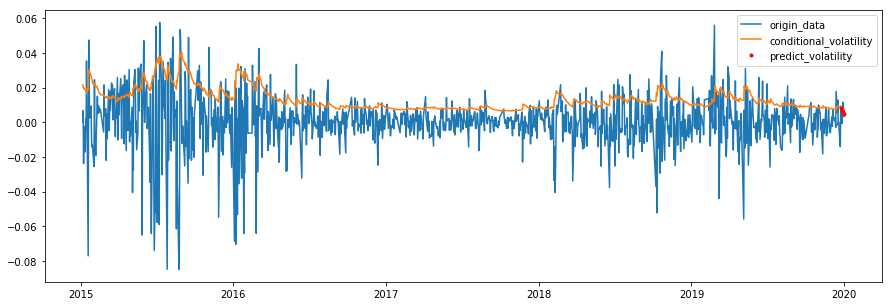

In [8]:
plt.figure(figsize=(15,5))
plt.plot(returns,label='origin_data')
x1=train_returns.index
plt.plot(x1,train_garch_result.conditional_volatility,label='conditional_volatility')
x2=test_returns.index
plt.plot(x2,vol_pre,'.r',label='predict_volatility')

plt.legend(loc=0)